In [1]:
import os
import scanpy as sc
from os.path import join

import sys
sys.path.insert(0, '../..')

from spamosaic.framework import SpaMosaic

In [2]:
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
data_dir = '/home/xuhua/xuhua_disco/gitrepo/BridgeNorm/SpaMosaic-release/data/integration/Simulation_datasets/dataset1/replicate1'

ad1_rna = sc.read_h5ad(join(data_dir, 's1_adata_rna.h5ad'))
ad1_adt = sc.read_h5ad(join(data_dir, 's1_adata_adt.h5ad'))
ad2_rna = sc.read_h5ad(join(data_dir, 's2_adata_rna.h5ad'))
ad3_adt = sc.read_h5ad(join(data_dir, 's3_adata_adt.h5ad'))

In [4]:
ad1_rna.obs['src'] = ad1_adt.obs['src'] = ['mult'] * ad1_rna.n_obs
ad2_rna.obs['src'] = ['rna'] * ad2_rna.n_obs
ad3_adt.obs['src'] = ['adt'] * ad3_adt.n_obs

### preprocessing

In [5]:
ad1_rna  # .X already normalzied

AnnData object with n_obs × n_vars = 1296 × 200
    obs: 'gt', 'ns_gt', 'kmeans', 'src'
    var: 'mean', 'std'
    uns: 'gt_colors', 'kmeans_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'nsfac', 'spatial', 'spfac'
    varm: 'PCs', 'nsload', 'spload'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, None],
    'adt': [ad1_adt, None,    ad3_adt]
}

input_key = 'X_pca'

In [7]:
for mod in input_dict.keys():
    ad_concat = sc.concat([ad for ad in input_dict[mod] if ad is not None])
    sc.pp.pca(ad_concat, n_comps=50)
    utls.split_adata_ob([ad for ad in input_dict[mod] if ad is not None], ad_concat, ob='obsm', key='X_pca')

### training

In [8]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knn=10, inter_knn=10, w_g=0.8, 
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.1, n_epochs=100)

batch0: ['rna', 'adt']
batch1: ['rna']
batch2: ['adt']
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
Number of mnn pairs for rna:4135
Number of mnn pairs for adt:4340


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.63it/s]


In [9]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


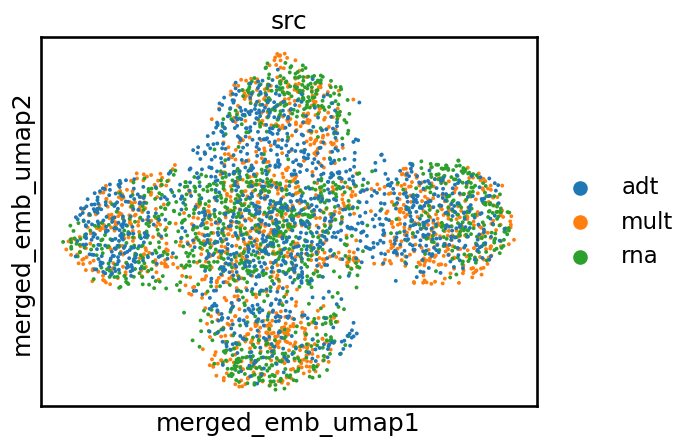

In [10]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

In [11]:
utls.clustering(ad_mosaic, n_cluster=5, used_obsm='merged_emb', algo='kmeans', key='kmeans')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'kmeans')

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


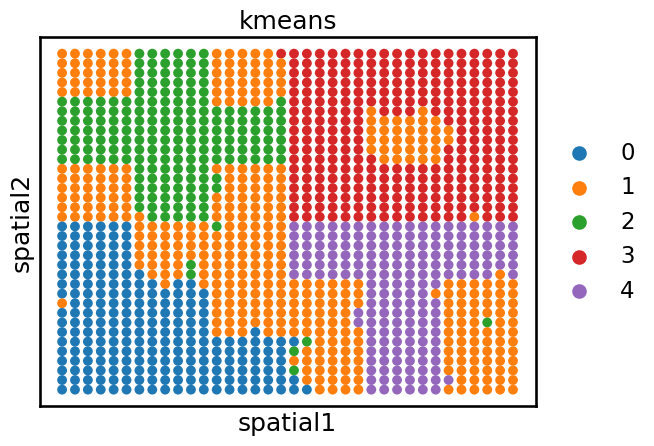

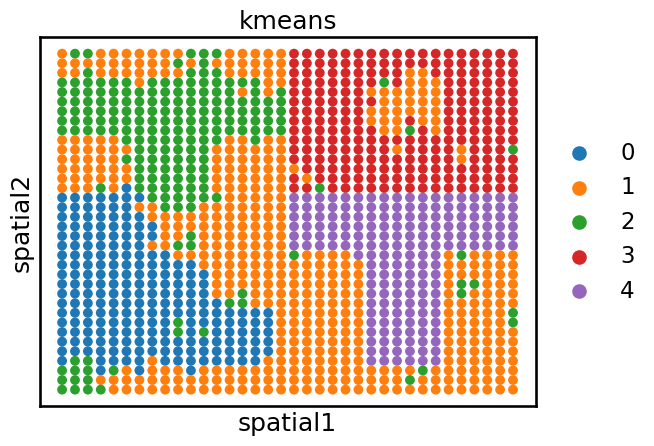

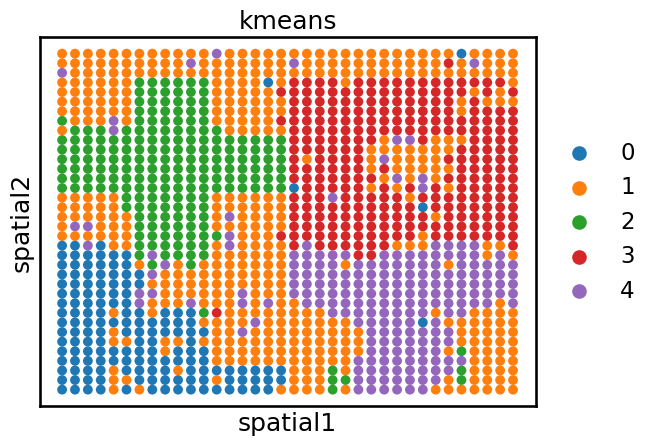

In [12]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'kmeans', s=200)